In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
cd ..

/home/osselinp/bo-on-graph


In [16]:
# test the GP cross validation
import torch
from search.trust_region import (
    restart,
)
from problems.generate_synthetic_graph import get_synthetic_problem
import matplotlib.pyplot as plt
from search.models import initialize_model
from search.utils import eigendecompose_laplacian
import networkx as nx
import gpytorch

In [82]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

In [83]:
model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 2,})

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/data/osselinp/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


In [84]:
t = torch.tensor(range(100), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)

IndexError: index 50 is out of bounds for dimension 0 with size 50

tensor([[0.6932]], grad_fn=<AddBackward0>)

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/data/osselinp/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


tensor([[-0.6604],
        [-0.3294],
        [-0.3318],
        [ 0.6627],
        [ 0.0303],
        [ 0.9038],
        [ 0.4864],
        [-0.5619],
        [ 0.2250],
        [ 1.0132],
        [-0.3024],
        [ 0.0364],
        [-0.0567],
        [-0.0202],
        [ 0.1916],
        [-1.6018],
        [-0.7130],
        [ 1.2066],
        [ 0.4469],
        [ 0.9502],
        [ 0.1796],
        [-0.3730],
        [-1.2621],
        [ 0.1914],
        [-0.4047],
        [-0.8507],
        [-1.2828],
        [ 0.5849],
        [ 1.3454],
        [ 0.5030],
        [ 1.7266],
        [-0.2124],
        [ 0.2869],
        [-0.9577],
        [ 1.6775],
        [-0.1887],
        [ 0.9970],
        [-0.3907],
        [ 0.2404],
        [-0.0952],
        [-1.0397],
        [ 0.4168],
        [-0.8024],
        [ 1.1078],
        [-1.0390],
        [ 0.3448],
        [ 0.3530],
        [ 0.1034],
        [-0.7641],
        [ 1.3386]])
beta: tensor([[0.6932]], grad_fn=<AddBackward0>)


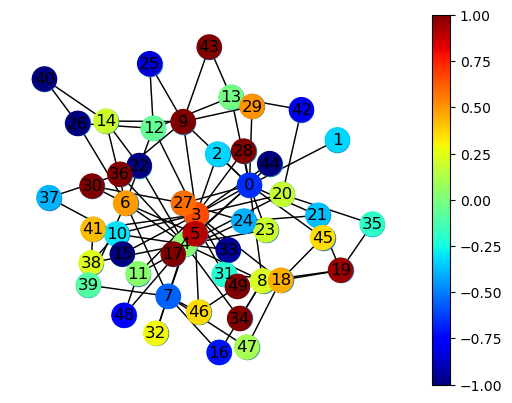

In [124]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 1,},
                         ard=True)
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)

model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
print(all_Y)
print("beta:", model.covar_module.base_kernel.lengthscale)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
plt.savefig( "realizations1.pdf",bbox_inches='tight')
plt.savefig( "realizations1.png",bbox_inches='tight')
plt.show()

In [105]:
dist.covariance_matrix

tensor([[ 6.9315e-01, -1.1728e-07, -2.9726e-08,  ..., -7.0564e-08,
          2.2638e-08,  2.1779e-08],
        [-1.1728e-07,  6.9315e-01,  1.0405e-07,  ..., -4.8929e-08,
         -5.6613e-08, -5.6573e-08],
        [-2.9726e-08,  1.0405e-07,  6.9315e-01,  ...,  1.3327e-07,
         -2.5398e-08,  2.4195e-08],
        ...,
        [-7.0564e-08, -4.8929e-08,  1.3327e-07,  ...,  6.9315e-01,
         -1.1289e-07,  7.8427e-09],
        [ 2.2638e-08, -5.6613e-08, -2.5398e-08,  ..., -1.1289e-07,
          6.9315e-01,  1.2802e-07],
        [ 2.1779e-08, -5.6573e-08,  2.4195e-08,  ...,  7.8427e-09,
          1.2802e-07,  6.9315e-01]], grad_fn=<AddmmBackward0>)

tensor([[1.7211],
        [0.4501],
        [0.6276],
        [1.9005],
        [1.6547],
        [0.9006],
        [1.2771],
        [1.1796],
        [1.0911],
        [1.2102],
        [1.0540],
        [0.8976],
        [0.9977],
        [0.8705],
        [0.9031],
        [0.6217],
        [0.6209],
        [0.7498],
        [1.0796],
        [0.9113],
        [0.8966],
        [0.7380],
        [0.6345],
        [0.6151],
        [0.7787],
        [0.6209],
        [0.7759],
        [0.8658],
        [0.6426],
        [0.6535],
        [0.6243],
        [0.6354],
        [0.6181],
        [0.6234],
        [0.6633],
        [0.6529],
        [0.7734],
        [0.6089],
        [0.7639],
        [0.6427],
        [0.6491],
        [0.6277],
        [0.6270],
        [0.6160],
        [0.6277],
        [0.6313],
        [0.7609],
        [0.6248],
        [0.6330],
        [0.6331]])


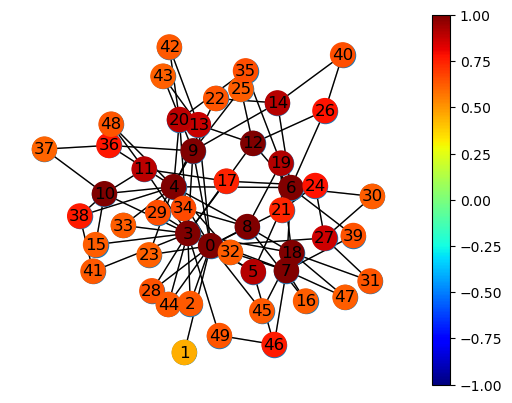

In [122]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 2,})
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)
model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
print(all_Y)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
plt.savefig( "realizations2.pdf",bbox_inches='tight')
plt.savefig( "realizations2.png",bbox_inches='tight')
plt.show()

tensor([[1.2429],
        [0.3356],
        [0.4680],
        [1.3541],
        [1.1723],
        [0.6372],
        [0.8926],
        [0.8505],
        [0.8181],
        [0.8792],
        [0.7733],
        [0.6213],
        [0.7485],
        [0.6579],
        [0.6231],
        [0.4310],
        [0.4667],
        [0.5397],
        [0.8173],
        [0.6576],
        [0.6258],
        [0.5431],
        [0.4703],
        [0.4446],
        [0.5316],
        [0.4666],
        [0.5613],
        [0.6502],
        [0.4652],
        [0.4450],
        [0.4597],
        [0.4500],
        [0.4395],
        [0.4452],
        [0.4417],
        [0.4721],
        [0.5527],
        [0.4347],
        [0.5365],
        [0.4375],
        [0.4436],
        [0.4275],
        [0.4663],
        [0.4796],
        [0.4564],
        [0.4595],
        [0.5479],
        [0.4908],
        [0.4529],
        [0.4488]])
beta: tensor([[0.6932, 0.6932, 0.6932]], grad_fn=<AddBackward0>)


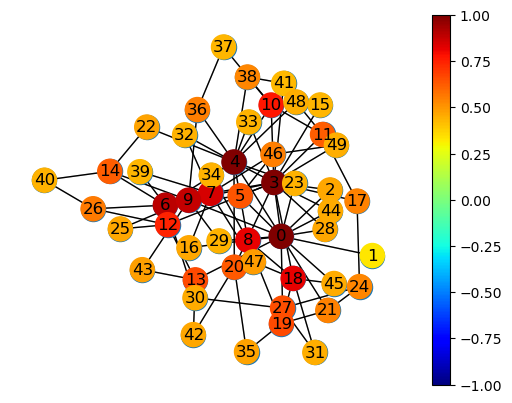

In [120]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 10,},
                         ard=True)
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)
model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
print(all_Y)
print("beta:", model.covar_module.base_kernel.lengthscale)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
#plt.savefig( "realizations2.pdf",bbox_inches='tight')
plt.show()

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/data/osselinp/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


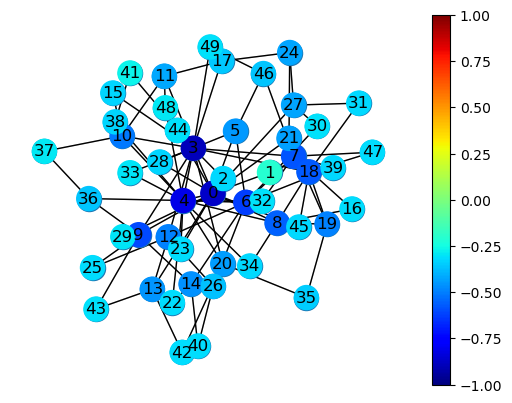

In [123]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 20,})
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)

model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
plt.savefig( "realizations.pdf",bbox_inches='tight')
plt.savefig( "realizations.png",bbox_inches='tight')
plt.show()

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/data/osselinp/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


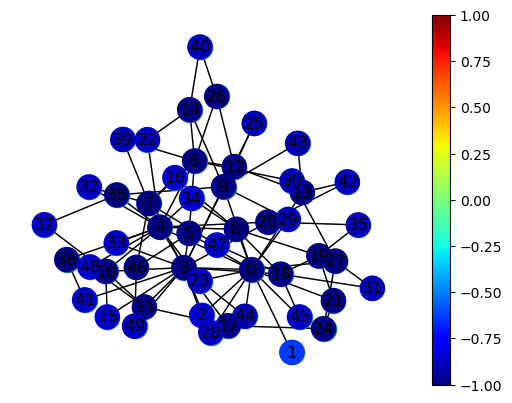

In [90]:
seed, n, m = 0, 50, 2
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 30,})
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)

model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
plt.savefig( "realizations2.pdf",bbox_inches='tight')
plt.show()

# Influence of Beta

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/data/osselinp/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


tensor([[-1.8979],
        [-1.0394],
        [-1.2162],
        [-0.8427],
        [-1.1894],
        [-1.6976],
        [-1.1985],
        [-0.9697],
        [-1.2044],
        [-0.2853],
        [-0.6817],
        [-0.6470],
        [-0.4941],
        [-0.8327],
        [-0.7762],
        [-0.5771],
        [-0.6604],
        [-0.8743],
        [-1.0009],
        [-0.4085],
        [-0.7016],
        [-0.3802],
        [-0.7391],
        [-0.5805],
        [-0.4474],
        [-0.6652],
        [-1.0883],
        [-0.8360],
        [-1.0700],
        [-0.5225],
        [-0.4249],
        [-0.8300],
        [-0.6505],
        [-0.5065],
        [-0.4912],
        [-0.4153],
        [-0.5913],
        [-0.6849],
        [-0.8835],
        [-0.7260],
        [-0.3274],
        [-0.6908],
        [-0.4758],
        [-1.1007],
        [-0.5408],
        [-0.4344],
        [-0.7287],
        [-0.6118],
        [-0.7220],
        [-0.2896]])
beta: tensor([[7.0000e-01, 1.0000e+04]], grad_fn=

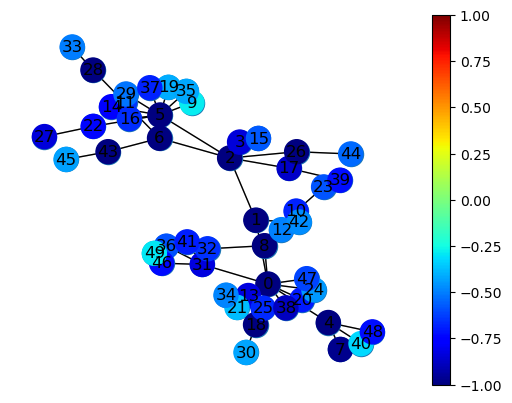

In [172]:
seed, n, m = 0, 50, 1
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

model, _, _ = initialize_model(train_X=torch.zeros((0,1), dtype=torch.float),
                         train_Y=torch.zeros((0,1), dtype=torch.float),
                         context_graph=g,
                         covar_type="polynomial",
                         covar_kwargs = {"order": 2,},
                         ard=True)
t = torch.tensor(range(n), dtype=torch.float).reshape(-1,1)
model.covar_module.base_kernel.lengthscale = torch.tensor([[0.7, 10000]])
model.eval()
dist = model(t)
pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)
nodes = g.nodes()

all_X = torch.tensor(range(n), dtype=torch.float)
t = all_X.reshape(-1,1)

model.eval()
dist = model(t)

all_Y = dist.sample().reshape(-1, 1)
print(all_Y)
print("beta:", model.covar_module.base_kernel.lengthscale)
# all_Y = eigenvecs[:, 0]
colors = all_Y
nx.draw_networkx(g, pos)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet, vmin=-1,vmax=1)
plt.colorbar(nc)
plt.axis('off')
plt.savefig( "realizations_beta1e4.pdf",bbox_inches='tight')
plt.savefig( "realizations_beta1e4.png",bbox_inches='tight')
plt.show()

In [54]:
nx.draw(g)


TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
nx.draw(g)

TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

In [59]:
g = nx.generators.random_graphs.barabasi_albert_graph(seed=seed, n=n, m=m)

In [60]:
g

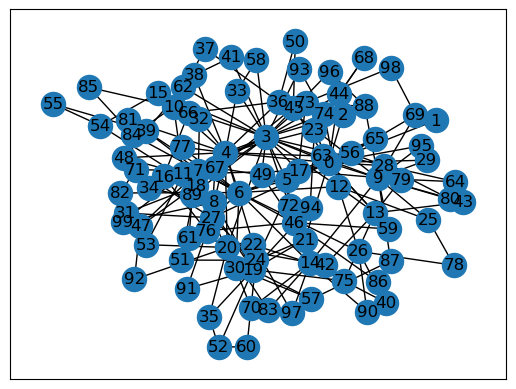

In [62]:
nx.draw_networkx(g)